In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd

train_path = "/content/drive/MyDrive/ML_data/train_dataset.csv"
station_path = "/content/drive/MyDrive/ML_data/station_info.csv"

train_df = pd.read_csv(train_path)
station_df = pd.read_csv(station_path)

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime

# ===== 데이터 전처리 함수들 =====

def dew_to_temp(dew, rh):
    a = 17.62
    b = 243.12
    gamma_inv = (a * dew) / (b + dew) - np.log(rh / 100.0)
    return (b * gamma_inv) / (a - gamma_inv)

def preprocess_data(df, station_df):
    df = df.copy()
    df.replace(-9999, np.nan, inplace=True)
    df['date_obj'] = pd.to_datetime('2024-' + df['date'], format='%Y-%m-%d', errors='coerce')
    df = df[df['date_obj'].notna()]  # 이상한 날짜 제거

    df['day_of_year'] = df['date_obj'].dt.dayofyear
    df['doy_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['doy_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    df.drop(columns=['date', 'date_obj'], inplace=True)

    zero_key = ['sunshine_duration', 'snow_depth', 'precipitation', 'visibility', 'wind_speed', 'cloud_cover']

    for col in df.columns:
        if any(key in col for key in zero_key):
            df[col].fillna(0, inplace=True)
        if "min_cloud_height" in col:
            df[col].fillna(df[col].max()+3, inplace=True)

    sum_col = ['visibility']
    mean_col = ['cloud_cover','wind_speed']

    for col in sum_col:
        df[f'{col}_sum'] = df[[f'{col}_{i}' for i in range(21)]].sum(axis=1)

    for col in mean_col:
        df[f'{col}_mean'] = df[[f'{col}_{i}' for i in range(21)]].mean(axis=1)

    # 원래 시간대별 열들 삭제
    drop_cols = [f'{col}_{i}' for col in (sum_col + mean_col) for i in range(21)]
    df.drop(columns=drop_cols, inplace=True)

    bf_nan_columns_list = df.columns[df.isnull().any()].tolist()

    for col in bf_nan_columns_list:
        df[col] = df.groupby(['day_of_year'])[col].transform(lambda x: x.fillna(x.mean()))

    for i in range(24):
        df[f'mag_temp_{i}'] = dew_to_temp(df[f'dew_point_{i}'], df[f'humidity_{i}'])

    df.drop(columns=['station_name', 'station', 'id'], inplace=True)
    return df

processed_df = preprocess_data(train_df, station_df)

<ipython-input-3-6dd1c2897cd9>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
<ipython-input-3-6dd1c2897cd9>:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col

In [4]:
processed_df.isna().sum().sum()

np.int64(0)

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

df = processed_df

X = df.drop(columns=['target'])
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=df['day_of_year'])

xgb_params =  {'device':'cuda','max_depth': 7, 'learning_rate': 0.05409400236764267, 'n_estimators': 670,
               'min_child_weight': 8, 'subsample': 0.817198601322624, 'colsample_bytree': 0.6388670310566312,
               'gamma': 0.36186946516047686, 'lambda': 6.072065371409787, 'alpha': 0.07418212565365712}

model = xgb.XGBRegressor(random_state=42, **xgb_params)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

train_rmse = mean_squared_error(y_train, train_pred)**(1/2)
val_rmse = mean_squared_error(y_val, val_pred)**(1/2)
print(f'✅ 트레인 RMSE: {train_rmse:.4f} °C')
print(f'✅ 검증 RMSE: {val_rmse:.4f} °C')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:33:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


✅ 트레인 RMSE: 0.3212 °C
✅ 검증 RMSE: 1.2663 °C


In [6]:
!pip install shap xgboost

100%|===================| 10500/10505 [10:45<00:00]       

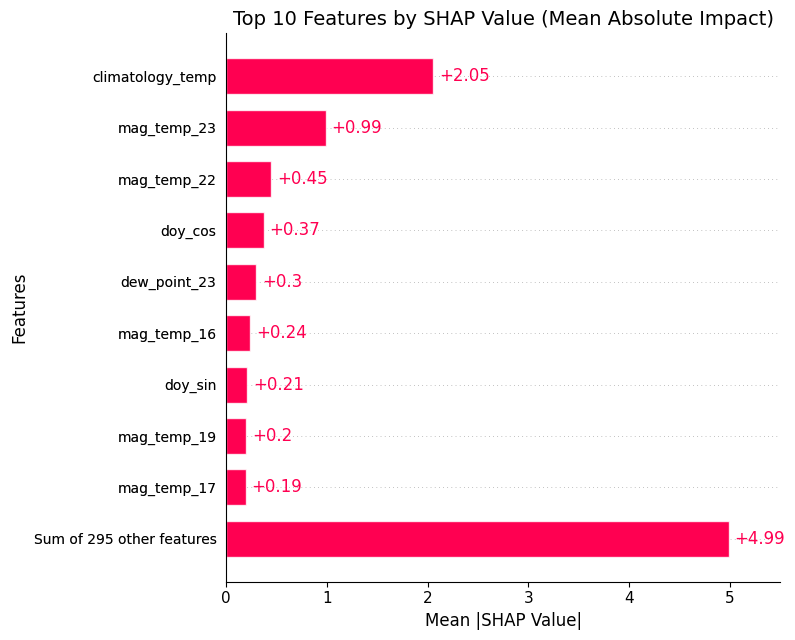

In [7]:
import shap
import matplotlib.pyplot as plt

# SHAP 값 계산
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# 시각화 설정
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values, max_display=10, show=False)

# 그래프 스타일 조정
plt.title("Top 10 Features by SHAP Value (Mean Absolute Impact)", fontsize=14)
plt.xlabel("Mean |SHAP Value|", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.gca().tick_params(axis='y', labelsize=10)
plt.tight_layout()

plt.show()

In [10]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
import xgboost as xgb
import numpy as np

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def objective(trial):
    params = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0),
        "device": "cuda"
    }

    X = processed_df.drop(columns=['target'])
    y = processed_df['target']

    model = xgb.XGBRegressor(**params)

    # KFold 설정 (필요시 StratifiedKFold 아님, 회귀니까)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # RMSE는 낮을수록 좋지만 cross_val_score는 높은 값이 좋은 방향이므로, 음수로 바꿔줌
    scores = cross_val_score(model, X, y, scoring=make_scorer(rmse_score, greater_is_better=False), cv=kf)

    # score는 음수 RMSE이므로 양수로 바꾸고 평균
    mean_rmse = -scores.mean()
    return mean_rmse

In [8]:
!pip install optuna xgboost scikit-learn

In [ ]:
import optuna

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  RMSE: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [12]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# 여기에 하이퍼파라미터 넣기
xgb_params =  {'device':'cuda', 'max_depth': 7, 'learning_rate': 0.05409400236764267, 'n_estimators': 670,
               'min_child_weight': 8, 'subsample': 0.817198601322624, 'colsample_bytree': 0.6388670310566312,
               'gamma': 0.36186946516047686, 'lambda': 6.072065371409787, 'alpha': 0.07418212565365712}

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['day_of_year'])

seeds = [12,29,53,77,111,123,404,333,222,923]
val_preds = []
test_preds = []
for seed in seeds:
    print(f"Training model with seed {seed}")
    model = xgb.XGBRegressor(random_state=seed, **xgb_params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    val_pred = model.predict(X_val)
    val_preds.append(val_pred)

# 앙상블 예측 평균
val_preds_mean = np.mean(val_preds, axis=0)

# 평가
rmse = mean_squared_error(y_val, val_preds_mean)**(1/2)
print(f"[Soft-Ensemble] Validation RMSE: {rmse:.4f}")

Training model with seed 12
Training model with seed 29
Training model with seed 53
Training model with seed 77
Training model with seed 111
Training model with seed 123
Training model with seed 404
Training model with seed 333
Training model with seed 222
Training model with seed 923
[Soft-Ensemble] Validation RMSE: 1.2436


In [13]:
models = []
for seed in seeds:
    print(f"Training model with seed {seed}")
    model = xgb.XGBRegressor(random_state=seed, **xgb_params)
    model.fit(X,y)
    models.append(model)

Training model with seed 12
Training model with seed 29
Training model with seed 53
Training model with seed 77
Training model with seed 111
Training model with seed 123
Training model with seed 404
Training model with seed 333
Training model with seed 222
Training model with seed 923


In [14]:
test_path = "/content/drive/MyDrive/ML_data/test_dataset.csv"
test_df = pd.read_csv(test_path)
test = preprocess_data(test_df, station_df)

<ipython-input-3-6dd1c2897cd9>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
<ipython-input-3-6dd1c2897cd9>:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col

In [15]:
final_preds = []
for m in models :
    pred = m.predict(test)
    final_preds.append(pred)
final = np.mean(final_preds, axis=0)

In [16]:
submission_df = pd.DataFrame({'target':final})
submission_df.to_csv('soft_final.csv',index=True, index_label='id')